In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import corner

import result_utils
import os; print(os.environ['LD_LIBRARY_PATH'])

/net/lem/data2/regt/MultiNest/lib:/software/rhel9-amd/lib64:


In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

cmap_A = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_A])
env_colors_A = cmap_A([0,1/4,2/4,3/4,1])
env_colors_A[:,3] = 0.5; env_colors_A[0,3] = 0.0

cmap_B = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_B])
env_colors_B = cmap_B([0,1/4,2/4,3/4,1])
env_colors_B[:,3] = 0.5; env_colors_B[0,3] = 0.0

lw_d = 0.8
lw_m = 1.0

res_alpha = 0.85

path = '/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs'
A = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_6/test_')
B = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_6/test_')
A_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_A_ret_2/test_')
B_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_B_ret_3/test_')

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_2/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_2/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_3/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_3/test_.txt


In [3]:
def get_chemical_ratios(Res, mean_along_axis=None, P=2.0):
    
    # Load the chemistry module
    Res.load_components(['Chem'])

    m_set = Res.model_settings[0]
    VMRs = Res.Chem[m_set].VMRs_posterior

    chem_ratios = {}
    chem_ratios['C/O'] = (
        (VMRs.get('12CO',0.)+VMRs.get('CH4',0.)+VMRs.get('13CO',0.)) / 
        (VMRs.get('12CO',0.)+VMRs.get('13CO',0.)+VMRs.get('H2O',0.))
    )

    # Isotope ratios
    chem_ratios['12CO/13CO'] = VMRs.get('12CO',0.) / VMRs.get('13CO',0.)
    chem_ratios['C16O/C18O'] = VMRs.get('12CO',0.) / VMRs.get('C18O',0.)
    chem_ratios['C16O/C17O'] = VMRs.get('12CO',0.) / VMRs.get('C17O',0.)
    
    chem_ratios['H2O/HDO'] = VMRs.get('H2O',0.) / VMRs.get('HDO',0.)
    chem_ratios['H2(16)O/H2(18)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(18)O',0.)
    chem_ratios['H2(16)O/H2(17)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(17)O',0.)

    chem_ratios['12CH4/13CH4'] = VMRs.get('CH4',0.) / VMRs.get('13CH4',0.)
    chem_ratios['14NH3/15NH3'] = VMRs.get('NH3',0.) / VMRs.get('15NH3',0.)
    
    # Absolute abundances
    abs_abund = {}
    solar = {'C':10**8.46, 'N':10**7.83, 'O':10**8.69, 'F':10**4.40, 'S':10**7.12, 'H':10**12.0}

    VMR_H = (
        VMRs.get('H2',0.)*2 + VMRs.get('H2O',0.)*2 + VMRs.get('CH4',0.)*4 + \
        VMRs.get('NH3',0.)*3 + VMRs.get('H2S',0.)*2 + VMRs.get('HF',0.)*1
    )
    VMR_C = VMRs.get('12CO',0.) + VMRs.get('CH4',0.) + VMRs.get('13CO',0.)
    VMR_N = VMRs.get('NH3',0.)
    VMR_O = VMRs.get('H2O',0.) + VMRs.get('12CO',0.) + VMRs.get('13CO',0.)
    VMR_F = VMRs.get('HF',0.)
    VMR_S = VMRs.get('H2S',0.)

    abs_abund['C/H'] = np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H'])
    abs_abund['N/H'] = np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H'])
    abs_abund['O/H'] = np.log10(VMR_O/VMR_H) - np.log10(solar['O']/solar['H'])
    abs_abund['F/H'] = np.log10(VMR_F/VMR_H) - np.log10(solar['F']/solar['H'])
    abs_abund['S/H'] = np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H'])
    abs_abund['(C+O)/H'] = (
        np.log10((VMR_C+VMR_O)/VMR_H) - np.log10((solar['C']+solar['O'])/solar['H'])
    )
    abs_abund['M/H'] = (
        np.log10((VMR_C+VMR_N+VMR_O+VMR_F+VMR_S)/VMR_H) - \
        np.log10((solar['C']+solar['N']+solar['O']+solar['F']+solar['S'])/solar['H'])
    )
    if mean_along_axis is not None:

        idx_P = np.argmin(np.abs(Res.Chem[m_set].pressure-P))
        keys = list(chem_ratios.keys())

        for key in keys:
            #chem_ratios[key] = np.mean(chem_ratios[key], axis=mean_along_axis)
            chem_ratios[key] = chem_ratios[key][:,idx_P]

            # For chemical equilibrium retrievals
            idx = Res.ParamTable.get(key, key='idx_free')
            if idx is not None:
                print(idx, key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = Res.posterior[:,idx]
            
            idx = Res.ParamTable.get(f'log_{key.split("/")[-1]}_ratio', key='idx_free')
            if idx is not None:
                print(idx, 'log_'+key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = 10**Res.posterior[:,idx]

        for key in abs_abund.keys():
            #abs_abund[key] = np.mean(abs_abund[key], axis=mean_along_axis)
            abs_abund[key] = abs_abund[key][:,idx_P]

        for key, VMR in VMRs.items():
            abs_abund[key] = VMR[:,idx_P]

    return chem_ratios, abs_abund

chem_ratios_A, abs_abund_A = get_chemical_ratios(A, mean_along_axis=-1)
chem_ratios_B, abs_abund_B = get_chemical_ratios(B, mean_along_axis=-1)

chem_ratios_A_eq, abs_abund_A_eq = get_chemical_ratios(A_eq, mean_along_axis=-1)
chem_ratios_B_eq, abs_abund_B_eq = get_chemical_ratios(B_eq, mean_along_axis=-1)

/var/tmp/regt/ipykernel_798421/3264040750.py:20: RuntimeWarning: divide by zero encountered in divide
  chem_ratios['H2O/HDO'] = VMRs.get('H2O',0.) / VMRs.get('HDO',0.)
/var/tmp/regt/ipykernel_798421/3264040750.py:24: RuntimeWarning: divide by zero encountered in divide
  chem_ratios['12CH4/13CH4'] = VMRs.get('CH4',0.) / VMRs.get('13CH4',0.)
/var/tmp/regt/ipykernel_798421/3264040750.py:25: RuntimeWarning: divide by zero encountered in divide
  chem_ratios['14NH3/15NH3'] = VMRs.get('NH3',0.) / VMRs.get('15NH3',0.)


8 C/O
11 log_12CO/13CO
12 log_C16O/C18O
13 log_C16O/C17O
14 log_H2(16)O/H2(18)O
15 log_H2(16)O/H2(17)O
8 C/O
11 log_12CO/13CO
12 log_C16O/C18O
13 log_C16O/C17O
14 log_H2(16)O/H2(18)O
15 log_H2(16)O/H2(17)O


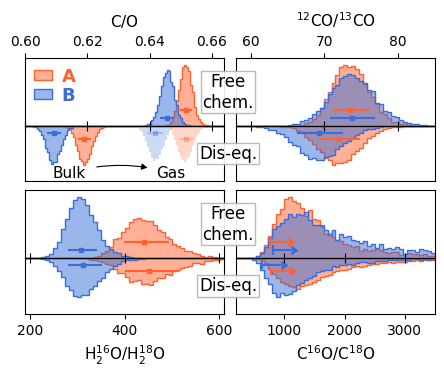

In [4]:
def plot_errorbar(ax, posterior, y, q, transform=None, **kwargs):

    x = np.median(posterior)
    xerr = np.quantile(posterior, q=q) - x
    xerr = np.abs(xerr)[:,None]

    if transform is None:
        transform = ax.get_xaxis_transform()

    if xerr.shape[0] == 1:
        ax.errorbar(
            x-xerr, y, yerr=0.07, transform=transform, fmt='', lw=1.5, ms=3.5, capsize=0, xlolims=True, **kwargs,
            )
    else:
        ax.errorbar(
            x, y, xerr=xerr, transform=transform, fmt='s', lw=1.5, ms=3.5, capsize=0, **kwargs,
            )

hist_kwargs_A = dict(
    #bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
    histtype='stepfilled', fc=env_colors_A[-1], ec=color_A, lw=lw_m, bottom=0, density=True
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_B[-1]
hist_kwargs_B['ec'] = color_B

hist_kwargs_A_eq = hist_kwargs_A.copy()
# hist_kwargs_A_eq['fc'] = env_colors_A[2]
# hist_kwargs_A_eq['hatch'] = '\\\\'

hist_kwargs_B_eq = hist_kwargs_B.copy()
# hist_kwargs_B_eq['fc'] = env_colors_B[2]
# hist_kwargs_B_eq['hatch'] = '//'

hist_kwargs_gas = hist_kwargs_A.copy()
hist_kwargs_gas.pop('fc', None)
hist_kwargs_gas['ec'] = 'none'
# hist_kwargs_gas['lw'] = 0.8

hist_info = {
    'C/O':             (100, [0.600, 0.664]), 
    '12CO/13CO':       (50, [58,85]), 
    'H2(16)O/H2(18)O': (50, [190,610]), 
    'C16O/C18O':       (50, [200,3500]), 
}

fig = plt.figure(figsize=(4.5,3.7))
gs = fig.add_gridspec(
    # nrows=5, ncols=2, hspace=0., wspace=0.08, height_ratios=[1,1,0.2,1,1],
    nrows=5, ncols=2, hspace=0., wspace=0.06, height_ratios=[1.1,0.9,0.15,1.1,0.9],
)
ax_1 = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
ax_2 = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
ax_2 += [fig.add_subplot(gs[4,0]), fig.add_subplot(gs[4,1])]
ax_1 += [fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1])]
ax_1 = np.array(ax_1)
ax_2 = np.array(ax_2)

for i, key in enumerate(hist_info.keys()):
    bins, hist_range = hist_info[key]

    handle_A = ax_1[i].hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
    handle_B = ax_1[i].hist(chem_ratios_B[key], label='B', bins=bins, range=hist_range, **hist_kwargs_B)
    ax_2[i].hist(chem_ratios_A_eq[key], bins=bins, range=hist_range, **hist_kwargs_A_eq)
    ax_2[i].hist(chem_ratios_B_eq[key], bins=bins, range=hist_range, **hist_kwargs_B_eq)

    if key == 'C/O':
        ax_2[i].hist(chem_ratios_A_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_A[2], **hist_kwargs_gas)
        ax_2[i].hist(chem_ratios_B_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_B[2], **hist_kwargs_gas)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[f'{key}_mean'], y=0.76, q=result_utils.q[[2,4]], color=color_A, alpha=0.3)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[f'{key}_mean'], y=0.88, q=result_utils.q[[2,4]], color=color_B, alpha=0.3)

    if key != 'C16O/C18O':
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[2,4]], color=color_A)
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[2,4]], color=color_B)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[2,4]], color=color_A)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[2,4]], color=color_B)
    else:
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[1]], color=color_A, xerr=300)
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[1]], color=color_B, xerr=300)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[1]], color=color_A, xerr=300)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[1]], color=color_B, xerr=300)


    ylim = ax_1[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.05]
    ax_1[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')

    ylim = ax_2[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.35]
    ax_2[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')
    ax_2[i].yaxis.set_inverted(True)

ax_1[0].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
ax_1[1].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
ax_2[0].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=7)
ax_2[1].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=7)

ax_1[2].tick_params(axis='x', labelbottom=False, direction='inout', length=7)
ax_1[3].tick_params(axis='x', labelbottom=False, direction='inout', length=7)

ax_1[0].set_xlabel(r'$\mathrm{C/O}$', fontsize=11, labelpad=6.0)
ax_1[1].set_xlabel(r'$\mathrm{^{12}CO/^{13}CO}$', fontsize=11, labelpad=6.0)
ax_2[2].set_xlabel(r'$\mathrm{H_2^{16}O/H_2^{18}O}$', fontsize=11)
ax_2[3].set_xlabel(r'$\mathrm{C^{16}O/C^{18}O}$', fontsize=11)

ax_1[0].xaxis.set_label_position('top')
ax_1[1].xaxis.set_label_position('top')

ann_kwargs = dict(
    xycoords='axes fraction', ha='center', va='center', fontsize=12, 
    bbox={'boxstyle':'square,pad=0.1', 'ec':'0.7', 'fc':'w', 'alpha':0.9}, 
)
for i in [1,3]:
    ax_1[i].annotate('Free\nchem.', xy=(-0.04,0.5), **ann_kwargs)
    ax_2[i].annotate('Dis-eq.', xy=(-0.04,0.5), **ann_kwargs)

ann_kwargs = dict(xycoords=ax_2[0].get_xaxis_transform(), ha='center', va='center', fontsize=11)

xy = (np.mean([np.median(chem_ratios_A_eq['C/O_mean']),np.median(chem_ratios_B_eq['C/O_mean'])]),0.15)
ax_2[0].annotate('Gas', xy=xy, **ann_kwargs)
xytext = (np.mean([np.median(chem_ratios_A_eq['C/O']),np.median(chem_ratios_B_eq['C/O'])]),0.15)
ax_2[0].annotate(
    'Bulk', xy=xy, xytext=xytext, **ann_kwargs, arrowprops=dict(
        arrowstyle='-|>,head_width=0.17,head_length=0.3', shrinkB=17, shrinkA=6, 
        connectionstyle='arc3,rad=-0.15', lw=0.8, color='k'
        )
    )

ax_1[0].legend(
    loc='upper left', bbox_to_anchor=(0.,1.), labelspacing=0.05, handlelength=1.0, handleheight=0.5, 
    handletextpad=0.5, borderpad=0., labelcolor=[color_A, color_B], prop={'weight':'bold', 'size':13}, frameon=False, 
)

plt.subplots_adjust(left=0.05, bottom=0.16, top=0.85, right=0.96)
plt.savefig(f'./plots/K_band_chem_ratios.pdf')
plt.show()

In [5]:
result_utils.latex_format(chem_ratios_A['C/O'], chem_ratios_B['C/O'], decimals=3)
result_utils.latex_format(chem_ratios_A['12CO/13CO'], chem_ratios_B['12CO/13CO'], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[[4,2]], decimals=0)
result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[0], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
result_utils.latex_format(chem_ratios_A['H2(16)O/H2(18)O'], chem_ratios_B['H2(16)O/H2(18)O'], decimals=0)

$0.652^{+0.002}_{-0.002}$ & $0.646^{+0.002}_{-0.002}$ \\
$74^{+3}_{-2}$ & $74^{+3}_{-3}$ \\
$764.0$ & $815.0$ \\
$441^{+52}_{-43}$ & $308^{+33}_{-28}$ \\


In [6]:
indices = [
    ('log_H2O', 2), 
    'log_H2(18)O', 
    'log_H2(17)O', 
    ('log_12CO', 2), 
    'log_13CO', 
    'log_C18O', 
    'log_C17O', 
    'log_CH4', 
    'log_NH3', 
    'log_H2S', 
    'log_HF', 
    'log_CO2', 
    'log_HCN', 
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    'dlnT_dlnP_1', 
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx = A.ParamTable.get(item, key='idx_free')
    result_utils.latex_format(A.posterior[:,idx], B.posterior[:,idx], decimals=decimals)

$-3.38^{+0.01}_{-0.01}$ & $-3.54^{+0.01}_{-0.01}$ \\
$-6.02^{+0.05}_{-0.05}$ & $-6.03^{+0.04}_{-0.04}$ \\
$-10.59^{+1.88}_{-1.89}$ & $-10.17^{+2.16}_{-2.16}$ \\
$-3.12^{+0.01}_{-0.01}$ & $-3.31^{+0.01}_{-0.01}$ \\
$-4.99^{+0.02}_{-0.02}$ & $-5.17^{+0.02}_{-0.02}$ \\
$-6.33^{+0.19}_{-1.58}$ & $-6.92^{+0.51}_{-4.12}$ \\
$-8.64^{+1.94}_{-2.88}$ & $-8.82^{+1.99}_{-2.96}$ \\
$-5.19^{+0.02}_{-0.02}$ & $-5.03^{+0.02}_{-0.01}$ \\
$-6.12^{+0.03}_{-0.04}$ & $-6.03^{+0.02}_{-0.02}$ \\
$-4.32^{+0.03}_{-0.03}$ & $-4.49^{+0.03}_{-0.03}$ \\
$-7.27^{+0.02}_{-0.02}$ & $-7.45^{+0.03}_{-0.03}$ \\
$-8.50^{+2.64}_{-3.05}$ & $-5.37^{+0.09}_{-0.10}$ \\
$-9.91^{+2.27}_{-2.27}$ & $-10.12^{+2.23}_{-2.21}$ \\
--------------------
$5.00^{+0.02}_{-0.02}$ & $4.74^{+0.02}_{-0.02}$ \\
$14.72^{+0.02}_{-0.02}$ & $24.79^{+0.05}_{-0.05}$ \\
$17.21^{+0.02}_{-0.01}$ & $19.75^{+0.03}_{-0.03}$ \\
--------------------
$0.23^{+0.06}_{-0.07}$ & $0.22^{+0.07}_{-0.07}$ \\
$0.33^{+0.01}_{-0.01}$ & $0.22^{+0.02}_{-0.02}$ \\
$0.051^

In [7]:
indices = [
    ('C/O', 3), 
    ('Fe/H', 2), 
    'log_13CO_ratio', 
    'log_C18O_ratio',
    'log_C17O_ratio',
    'log_H2(18)O_ratio',
    'log_H2(17)O_ratio',
    'log_Kzz_chem',
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    'dlnT_dlnP_1', 
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx = A_eq.ParamTable.get(item, key='idx_free')
    result_utils.latex_format(A_eq.posterior[:,idx], B_eq.posterior[:,idx], decimals=decimals)

$0.619^{+0.002}_{-0.002}$ & $0.609^{+0.002}_{-0.002}$ \\
$0.18^{+0.01}_{-0.01}$ & $0.17^{+0.02}_{-0.02}$ \\
$1.86^{+0.02}_{-0.02}$ & $1.84^{+0.02}_{-0.02}$ \\
$3.18^{+0.26}_{-0.17}$ & $3.08^{+0.24}_{-0.15}$ \\
$3.79^{+0.56}_{-0.37}$ & $3.32^{+0.32}_{-0.20}$ \\
$2.65^{+0.06}_{-0.05}$ & $2.49^{+0.05}_{-0.05}$ \\
$4.43^{+0.36}_{-0.42}$ & $4.19^{+0.50}_{-0.49}$ \\
$8.97^{+0.55}_{-0.14}$ & $9.03^{+0.08}_{-0.07}$ \\
--------------------
$5.01^{+0.02}_{-0.02}$ & $4.95^{+0.02}_{-0.02}$ \\
$14.90^{+0.02}_{-0.02}$ & $25.07^{+0.05}_{-0.05}$ \\
$17.24^{+0.02}_{-0.02}$ & $19.77^{+0.03}_{-0.03}$ \\
--------------------
$0.23^{+0.07}_{-0.08}$ & $0.22^{+0.07}_{-0.07}$ \\
$0.30^{+0.03}_{-0.03}$ & $0.29^{+0.02}_{-0.02}$ \\
$0.052^{+0.002}_{-0.001}$ & $0.082^{+0.003}_{-0.003}$ \\
$0.30^{+0.02}_{-0.02}$ & $0.27^{+0.02}_{-0.02}$ \\
$0.12^{+0.10}_{-0.08}$ & $0.11^{+0.10}_{-0.07}$ \\
$-0.37^{+0.03}_{-0.02}$ & $-0.36^{+0.04}_{-0.04}$ \\
$1171^{+7}_{-7}$ & $1080^{+14}_{-12}$ \\


$1.52^{+0.17}_{-0.21}$ & $1.79^{+0.13}_{-0.16}$ \\
$0.65^{+0.08}_{-0.07}$ & $0.59^{+0.12}_{-0.06}$ \\
--------------------
$-1.08^{+0.03}_{-0.03}$ & $-1.38^{+0.03}_{-0.04}$ \\
$0.52^{+0.02}_{-0.01}$ & $0.52^{+0.02}_{-0.01}$ \\
$1.03^{+0.03}_{-0.02}$ & $1.02^{+0.02}_{-0.01}$ \\
--------------------
$0.213^{+0.005}_{-0.005}$ & $0.115^{+0.005}_{-0.006}$ \\
$-1.296^{+0.006}_{-0.005}$ & $-1.328^{+0.008}_{-0.010}$ \\


# Abundance profiles in dis-equilibrium

In [8]:
contr_A_eq = A_eq.get_contribution_function()
contr_B_eq = B_eq.get_contribution_function()

In [9]:
def plot_envelopes(ax, y, x, x_indices=[[0,6]], fc=[], median_kwargs={}, **fill_betweenx_kwargs):
    
    patch = None
    for i, (idx_l, idx_u) in enumerate(x_indices):
        patch = ax.fill_betweenx(
            y=y, x1=x[idx_l], x2=x[idx_u], fc=fc[i], **fill_betweenx_kwargs
            )
    
    line = None
    if len(median_kwargs) > 0:
        idx_m = median_kwargs.get('idx', 3)
        median_kwargs.pop('idx', None)

        line, = ax.plot(x[idx_m], y, **median_kwargs)
    
    return (line, patch, line)

def plot_VMR_envelope(ax, Chem, species, median_kwargs={}, **fill_betweenx_kwargs):

    VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    plot_envelopes(
        ax, Chem.pressure, VMR_q, median_kwargs=median_kwargs, **fill_betweenx_kwargs, 
        )

def plot_VMR_errorbar(ax, Chem, species, y=1, x_indices=[[0,6],[1,5],[2,4]], **errorbar_kwargs):
    
    VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    VMR_q = np.median(VMR_q, axis=-1)
    
    x = VMR_q[3]
    xerr = np.array([VMR_q[x_indices[i]] for i in range(len(x_indices))])
    xerr = np.abs(xerr-x).T

    x = np.repeat(x, len(x_indices))
    y = np.repeat(y, len(x_indices))
    ax.errorbar(x, y, xerr=xerr, **errorbar_kwargs)

log_Kzz_chem:
$8.97^{+0.55}_{-0.14}$ & $9.03^{+0.08}_{-0.07}$ \\


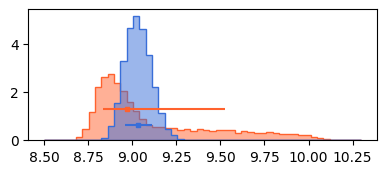

In [10]:
log_Kzz_A_eq = A_eq.posterior[:,A_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]
log_Kzz_B_eq = B_eq.posterior[:,B_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]

print('log_Kzz_chem:')
result_utils.latex_format(log_Kzz_A_eq, log_Kzz_B_eq, decimals=2)

bins = 50; hist_range = [8.5,10.3]
fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(log_Kzz_A_eq, label='A', bins=bins, range=hist_range, **hist_kwargs_A_eq)
ax.hist(log_Kzz_B_eq, label='B', bins=bins, range=hist_range, **hist_kwargs_B_eq)
# ax.hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
plot_errorbar(ax, log_Kzz_A_eq, y=0.24, q=result_utils.q[[2,4]], color=color_A)
plot_errorbar(ax, log_Kzz_B_eq, y=0.12, q=result_utils.q[[2,4]], color=color_B)

plt.show()

In [13]:
from tqdm import tqdm
import copy

A_eq.load_components(['PT'])
B_eq.load_components(['PT'])

# Turn off the quenching
# A_eq.Chem['K2166_1'].quench_VMRs = lambda *args, **kwargs: None
# B_eq.Chem['K2166_1'].quench_VMRs = lambda *args, **kwargs: None

Chem_A_eq_wo_quenching = copy.deepcopy(A_eq.Chem['K2166_1'])
Chem_B_eq_wo_quenching = copy.deepcopy(B_eq.Chem['K2166_1'])

idx_A = list(np.random.randint(0, A_eq.posterior.shape[0], size=1000))
idx_B = list(np.random.randint(0, B_eq.posterior.shape[0], size=1000))

Chem_A_eq_wo_quenching.quench_settings_posterior = {key: [] for key in Chem_A_eq_wo_quenching.quench_settings.keys()}
Chem_B_eq_wo_quenching.quench_settings_posterior = {key: [] for key in Chem_B_eq_wo_quenching.quench_settings.keys()}
Chem_A_eq_wo_quenching.VMRs_posterior = {species: [] for species in Chem_A_eq_wo_quenching.VMRs.keys()}
Chem_B_eq_wo_quenching.VMRs_posterior = {species: [] for species in Chem_B_eq_wo_quenching.VMRs.keys()}

for i, sample in enumerate(tqdm(A_eq.posterior[idx_A], desc='A_eq')):
    # Update the parameters
    A_eq.ParamTable.set_apply_prior(False)
    A_eq.ParamTable(cube=sample)
    A_eq.ParamTable.set_apply_prior(True)

    # Calculate the VMRs
    Chem_A_eq_wo_quenching(A_eq.ParamTable, A_eq.PT['K2166_1'].temperature_posterior[idx_A][i])
    for species in Chem_A_eq_wo_quenching.VMRs_posterior.keys():
        Chem_A_eq_wo_quenching.VMRs_posterior[species].append(Chem_A_eq_wo_quenching.VMRs[species])

    for key, value in Chem_A_eq_wo_quenching.quench_settings.items():
        Chem_A_eq_wo_quenching.quench_settings_posterior[key].append(value[-1])
        
for i, sample in enumerate(tqdm(B_eq.posterior[idx_B], desc='B_eq')):
    # Update the parameters
    B_eq.ParamTable.set_apply_prior(False)
    B_eq.ParamTable(cube=sample)
    B_eq.ParamTable.set_apply_prior(True)

    # Calculate the VMRs
    Chem_B_eq_wo_quenching(B_eq.ParamTable, B_eq.PT['K2166_1'].temperature_posterior[idx_B][i])
    for species in Chem_B_eq_wo_quenching.VMRs_posterior.keys():
        Chem_B_eq_wo_quenching.VMRs_posterior[species].append(Chem_B_eq_wo_quenching.VMRs[species])

    for key, value in Chem_B_eq_wo_quenching.quench_settings.items():
        Chem_B_eq_wo_quenching.quench_settings_posterior[key].append(value[-1])

# Convert the lists to numpy arrays
for key in Chem_A_eq_wo_quenching.quench_settings_posterior.keys():
    Chem_A_eq_wo_quenching.quench_settings_posterior[key] = np.array(Chem_A_eq_wo_quenching.quench_settings_posterior[key])
    Chem_B_eq_wo_quenching.quench_settings_posterior[key] = np.array(Chem_B_eq_wo_quenching.quench_settings_posterior[key])

B_eq: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.04it/s]


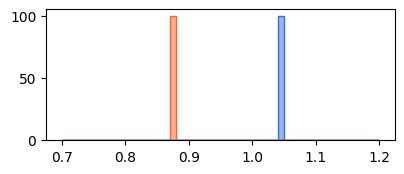

In [15]:
bins = 50; hist_range = [0.7,1.2]
fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(
    np.log10(Chem_A_eq_wo_quenching.quench_settings_posterior['CO_CH4']), 
    label='A', bins=bins, range=hist_range, **hist_kwargs_A_eq
    )
ax.hist(
    np.log10(Chem_B_eq_wo_quenching.quench_settings_posterior['CO_CH4']),
    label='B', bins=bins, range=hist_range, **hist_kwargs_B_eq
    )

plt.show()

[7.54312006]


(0.0, 10.0)

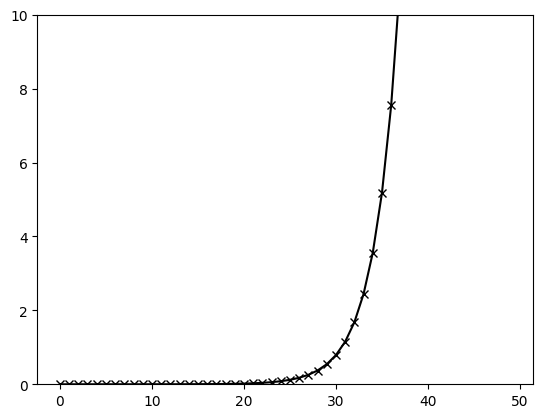

In [20]:
print(np.unique(Chem_A_eq_wo_quenching.quench_settings_posterior['CO_CH4']))

plt.plot(A_eq.PT['K2166_1'].pressure, 'k-x')
plt.ylim(0,10)

In [22]:
A_eq.Chem['K2166_1'].temperature

array([ 150.66591632,  157.73626076,  165.50468043,  174.04086504,
        183.42325702,  193.74021756,  205.09136699,  217.58912763,
        231.36050135,  246.54912011,  263.31761432,  281.85035161,
        302.35660811,  325.07424532,  350.27397894,  378.26434169,
        409.39746093,  444.07579419,  482.75999264,  525.97809442,
        574.33628828,  628.53153401,  689.36638173,  757.76639892,
        834.8006944 ,  921.70612613, 1017.17524975, 1097.54529974,
       1157.90381281, 1190.50217146, 1232.67054634, 1290.15994648,
       1364.95960737, 1459.74082179, 1578.01604853, 1724.35542199,
       1886.20143443, 2064.24788627, 2260.20650372, 2475.97859522,
       2713.67694811, 2975.65035205, 3264.51107552, 3583.16566348,
       3934.84947174, 4323.16540697, 4752.12740242, 5226.20922799,
       5750.39931176, 6330.2623382 ])

In [33]:
from retrieval_base.utils import sc

# Metallicity
m = 10**A_eq.Chem['K2166_1'].FeH

# Scale height at each layer
kB  = sc.k * 1e7
amu = sc.amu * 1e3  # Convert to cgs (g)
H = kB*A_eq.Chem['K2166_1'].temperature / (A_eq.Chem['K2166_1'].MMW*amu * A_eq.ParamTable.get('g'))

# Mixing length/time-scales
alpha = 1
L = alpha * H
t_mix = L**2 / A_eq.ParamTable.get('Kzz_chem')

inv_t_q1 = 1e6/1.5 * A_eq.Chem['K2166_1'].pressure * m**0.7 * np.exp(-42000/A_eq.Chem['K2166_1'].temperature)
inv_t_q2 = 1/40 * A_eq.Chem['K2166_1'].pressure**2 * np.exp(-25000/A_eq.Chem['K2166_1'].temperature)
t_CO_CH4 = 1/(inv_t_q1 + inv_t_q2)

t_NH3 = 1.0e-7 * A_eq.Chem['K2166_1'].pressure**(-1) * np.exp(52000/A_eq.Chem['K2166_1'].temperature)

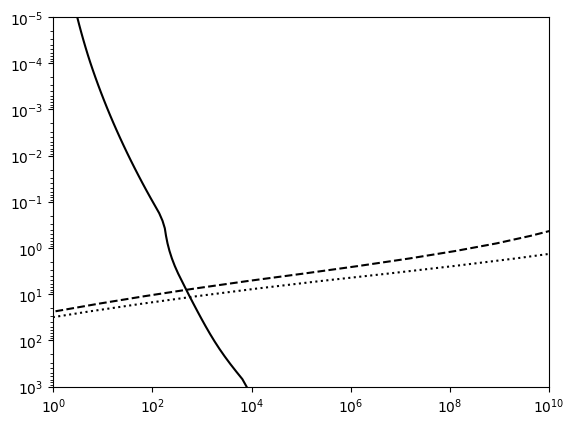

In [36]:
plt.plot(t_mix, A_eq.Chem['K2166_1'].pressure, 'k-', label='Mixing time-scale')
plt.plot(t_CO_CH4, A_eq.Chem['K2166_1'].pressure, 'k--', label='CO-CH4 chemical time-scale')
plt.plot(t_NH3, A_eq.Chem['K2166_1'].pressure, 'k:', label='NH3 chemical time-scale')
plt.xscale('log'); plt.yscale('log')
plt.ylim(1e3,1e-5)
plt.xlim(1e0, 1e10)
plt.show()

0.18041292171372092

In [13]:
import copy
Chem_A_eq_copy = copy.deepcopy(A_eq.Chem['K2166_1'])
Chem_B_eq_copy = copy.deepcopy(B_eq.Chem['K2166_1'])

Chem_A_eq_copy.VMRs_posterior = VMRs_posterior_wo_quenching_A
Chem_B_eq_copy.VMRs_posterior = VMRs_posterior_wo_quenching_B

/var/tmp/regt/ipykernel_789373/2568178535.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(


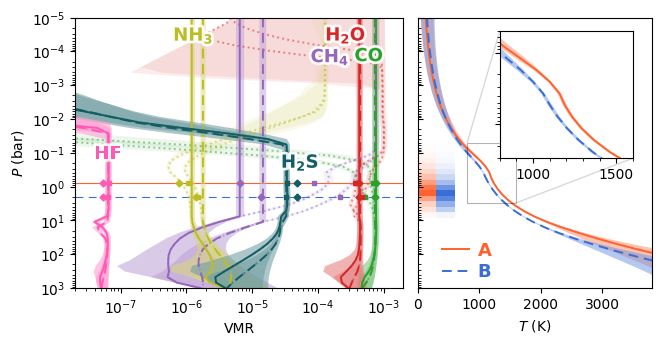

In [16]:
species_info = {
    '12CO': ('C2', 'CO', (0.0,-0.08)), 
    'H2O': ('C3', 'H_2O', (-0.2,0)),
    'CH4': ('C4', 'CH_4', (0,-0.08)),
    'NH3': ('C8', 'NH_3', (0,0)),
    'H2S': ('#135D64', 'H_2S', (+0.2,-0.47)),
    'HF': ('#FF59B4', 'HF', (0,-0.44)),
}
y_A = 10**(-0.1)
y_B = 10**(+0.3)

A.load_components(['PT'])
B.load_components(['PT'])
A_eq.load_components(['PT'])
B_eq.load_components(['PT'])

fig = plt.figure(figsize=(9,3.3))
gs = fig.add_gridspec(
    nrows=1, ncols=4, hspace=0., wspace=0.08, width_ratios=[0.45,0.05,0.25,0.25],
)

ax_contr = fig.add_subplot(gs[0,1])
ax_VMR = fig.add_subplot(gs[0,0])
ax_PT = fig.add_subplot(gs[0,1:3])

ax_ins = ax_PT.inset_axes(
    bounds=(0.35,0.48,0.57,0.47), transform=ax_PT.transAxes, #xlim=(1000,1500), ylim=(1e1,1e-1), 
)

ax_contr.imshow(
    contr_A_eq['K2166_1'].reshape(-1,1), cmap=cmap_A, aspect='auto', interpolation='none', 
    extent=[0,0.5,0,1], transform=ax_contr.transAxes, 
)
ax_contr.imshow(
    contr_B_eq['K2166_1'].reshape(-1,1), cmap=cmap_B, aspect='auto', interpolation='none', 
    extent=[0.5,1,0,1], transform=ax_contr.transAxes, 
)

for species, (c, l, xy) in species_info.items():
    l = r'$\mathrm{\bf '+f'{l}'+'}$'

    # fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.4,0.6,0.8])
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    # ax_VMR.plot(
    #     A_eq.Chem['K2166_1'].VMRs[species], A_eq.PT['K2166_1'].pressure, lw=0.8, ls=':', c=c, zorder=-1, alpha=0.5
    #     )
    # ax_VMR.plot(
    #     B_eq.Chem['K2166_1'].VMRs[species], B_eq.PT['K2166_1'].pressure, lw=0.8, ls=':', c=c, zorder=-1, alpha=0.5
    #     )
    
    plot_VMR_envelope(
        ax_VMR, Chem_A_eq_copy, species, median_kwargs=dict(c=c, lw=1.4, ls=':', alpha=0.5), **dict(fc=fc, ec='none', alpha=0.15)
        )
    plot_VMR_envelope(
        ax_VMR, Chem_B_eq_copy, species, median_kwargs=dict(c=c, lw=1.4, ls=':', alpha=0.5), **dict(fc=fc, ec='none', alpha=0.15)
        )
    
    plot_errorbar(
        ax_VMR, abs_abund_A_eq[species], y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
        )
    plot_VMR_envelope(
        ax_VMR, A_eq.Chem['K2166_1'], species, median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )

    plot_errorbar(
        ax_VMR, abs_abund_B_eq[species], y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
        )
    plot_VMR_envelope(
        ax_VMR, B_eq.Chem['K2166_1'], species, median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )

    # '''
    plot_errorbar(
        ax_VMR, 10**(np.log10(abs_abund_A[species])+0.003513443261954352), y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData, marker='D'
        # ax_VMR, 10**(np.log10(abs_abund_A[species])+0.003513443261954352), y=y_A, q=result_utils.q[[0,-1]], color=c, transform=ax_VMR.transData, marker='D'
        # ax_VMR, abs_abund_A[species], y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
    )
    plot_errorbar(
        ax_VMR, 10**(np.log10(abs_abund_B[species])+0.171961846449475), y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData, marker='D'
        # ax_VMR, 10**(np.log10(abs_abund_B[species])+0.171961846449475), y=y_B, q=result_utils.q[[0,-1]], color=c, transform=ax_VMR.transData, marker='D'
        # ax_VMR, abs_abund_B[species], y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
    )
    # '''

    x = np.mean([np.median(abs_abund_A_eq[species]), np.median(abs_abund_B_eq[species])])
    x = 10**(np.log10(x)+xy[0])

    y = 0.97 + xy[1]

    ax_VMR.annotate(
        l, xy=(x,y), xycoords=ax_VMR.get_xaxis_transform(), ha='center', va='top', fontsize=13, c=c, 
        path_effects=[pe.withStroke(linewidth=4, foreground='w', alpha=0.9)],
        # bbox={'boxstyle':'square,pad=0.1', 'ec':'0.7', 'fc':'w', 'alpha':0.9}, 
        )

    # ax_VMR.annotate(
    #     species_i, xy=(pos_x_i, 0.02), xycoords=ax_VMR.get_xaxis_transform(), zorder=2, 
    #     clip_on=True, ha=ha, va='bottom', c=color_i, fontsize=13, fontweight='bold', 
    #     path_effects=[pe.withStroke(linewidth=5, foreground='w', alpha=0.9)],
    # )

for ax_i in [ax_PT, ax_ins]:
    temperature_q = result_utils.profile_quantiles(A_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, A_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_A, lw=1.4), 
        **dict(fc=env_colors_A[3:], ec='none', alpha=0.5)
        )

    temperature_q = result_utils.profile_quantiles(B_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, B_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
        **dict(fc=env_colors_B[3:], ec='none', alpha=0.5)
        )

ax_VMR.plot([0.,1.0], [y_A]*2, transform=ax_VMR.get_yaxis_transform(), lw=0.8, c=color_A, zorder=-1, alpha=1)
ax_VMR.plot([0.,1.0], [y_B]*2, transform=ax_VMR.get_yaxis_transform(), lw=0.8, c=color_B, ls=(0,(7,5)), zorder=-1, alpha=1)

handle_A, = ax_PT.plot(np.nan, np.nan, color=color_A, lw=1.4, label='A')
handle_B, = ax_PT.plot(np.nan, np.nan, color=color_B, lw=1.4, ls=(0,(5,3)), label='B')
ax_PT.legend(
    loc='lower left', bbox_to_anchor=(0.07,0), frameon=False, 
    handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderaxespad=0.0, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)

ax_contr.set_axis_off()
ax_contr.set(yticks=[], xticks=[])

ax_VMR.set(
    xscale='log', xlim=(10**(-7.7), 10**(-2.7)), xlabel='VMR', 
    yscale='log', ylim=(1e3, 1e-5), ylabel=r'$P$ (bar)', 
    )

ax_ins.set_xticks([800,900,1100,1200,1300,1400,1600], minor=True)
ax_ins.set(yscale='log', xlim=(800,1600), ylim=(3e0,5e-2), yticklabels=[])
ax_PT.indicate_inset_zoom(ax_ins, ec='k', lw=0.8, alpha=0.3)

ax_PT.tick_params(axis='y', which='both', direction='in')
ax_PT.set(
    xlim=(0,3800), xlabel=r'$T$ (K)', xticks=[0,1000,2000,3000],
    yscale='log', ylim=(1e3, 1e-5), yticklabels=[], facecolor='none', 
)

# plt.subplots_adjust(left=0.16, bottom=0.14, top=0.96, right=0.97)
plt.subplots_adjust(left=0.11, bottom=0.14, top=0.96, right=0.97)
plt.savefig('./plots/K_band_VMR_profiles.pdf')
plt.show()

/var/tmp/regt/ipykernel_487477/2568178535.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(


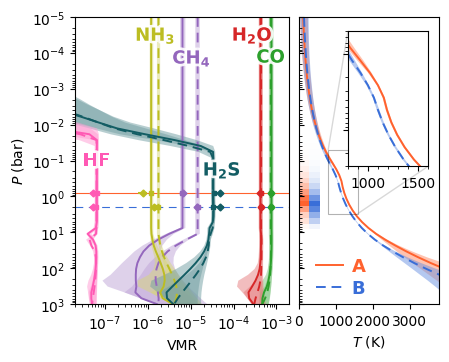

In [14]:
species_info = {
    '12CO': ('C2', 'CO', (0.0,-0.08)), 
    'H2O': ('C3', 'H_2O', (-0.2,0)),
    'CH4': ('C4', 'CH_4', (0,-0.08)),
    'NH3': ('C8', 'NH_3', (0,0)),
    'H2S': ('#135D64', 'H_2S', (+0.2,-0.47)),
    'HF': ('#FF59B4', 'HF', (0,-0.44)),
}
y_A = 10**(-0.1)
y_B = 10**(+0.3)

A.load_components(['PT'])
B.load_components(['PT'])
A_eq.load_components(['PT'])
B_eq.load_components(['PT'])

fig = plt.figure(figsize=(4.5,3.5))
gs = fig.add_gridspec(
    nrows=1, ncols=3, hspace=0., wspace=0.08, width_ratios=[0.62,0.06,0.32],
)

ax_contr = fig.add_subplot(gs[0,1])
ax_VMR = fig.add_subplot(gs[0,0])
ax_PT = fig.add_subplot(gs[0,1:])

ax_ins = ax_PT.inset_axes(
    bounds=(0.35,0.48,0.57,0.47), transform=ax_PT.transAxes, #xlim=(1000,1500), ylim=(1e1,1e-1), 
)

ax_contr.imshow(
    contr_A_eq['K2166_1'].reshape(-1,1), cmap=cmap_A, aspect='auto', interpolation='none', 
    extent=[0,0.5,0,1], transform=ax_contr.transAxes, 
)
ax_contr.imshow(
    contr_B_eq['K2166_1'].reshape(-1,1), cmap=cmap_B, aspect='auto', interpolation='none', 
    extent=[0.5,1,0,1], transform=ax_contr.transAxes, 
)

for species, (c, l, xy) in species_info.items():
    l = r'$\mathrm{\bf '+f'{l}'+'}$'

    # fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.4,0.6,0.8])
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    plot_errorbar(
        ax_VMR, abs_abund_A_eq[species], y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
        )
    plot_VMR_envelope(
        ax_VMR, A_eq.Chem['K2166_1'], species, median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )

    plot_errorbar(
        ax_VMR, abs_abund_B_eq[species], y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
        )
    plot_VMR_envelope(
        ax_VMR, B_eq.Chem['K2166_1'], species, median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )

    # '''
    plot_errorbar(
        # ax_VMR, 10**(np.log10(abs_abund_A[species])+0.003513443261954352), y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData, marker='D'
        ax_VMR, 10**(np.log10(abs_abund_A[species])+0.003513443261954352), y=y_A, q=result_utils.q[[0,-1]], color=c, transform=ax_VMR.transData, marker='D'
        # ax_VMR, abs_abund_A[species], y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
    )
    plot_errorbar(
        # ax_VMR, 10**(np.log10(abs_abund_B[species])+0.171961846449475), y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData, marker='D'
        ax_VMR, 10**(np.log10(abs_abund_B[species])+0.171961846449475), y=y_B, q=result_utils.q[[0,-1]], color=c, transform=ax_VMR.transData, marker='D'
        # ax_VMR, abs_abund_B[species], y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_VMR.transData
    )
    # '''

    x = np.mean([np.median(abs_abund_A_eq[species]), np.median(abs_abund_B_eq[species])])
    x = 10**(np.log10(x)+xy[0])

    y = 0.97 + xy[1]

    ax_VMR.annotate(
        l, xy=(x,y), xycoords=ax_VMR.get_xaxis_transform(), ha='center', va='top', fontsize=13, c=c, 
        path_effects=[pe.withStroke(linewidth=4, foreground='w', alpha=0.9)],
        # bbox={'boxstyle':'square,pad=0.1', 'ec':'0.7', 'fc':'w', 'alpha':0.9}, 
        )

    # ax_VMR.annotate(
    #     species_i, xy=(pos_x_i, 0.02), xycoords=ax_VMR.get_xaxis_transform(), zorder=2, 
    #     clip_on=True, ha=ha, va='bottom', c=color_i, fontsize=13, fontweight='bold', 
    #     path_effects=[pe.withStroke(linewidth=5, foreground='w', alpha=0.9)],
    # )

for ax_i in [ax_PT, ax_ins]:
    temperature_q = result_utils.profile_quantiles(A_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, A_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_A, lw=1.4), 
        **dict(fc=env_colors_A[3:], ec='none', alpha=0.5)
        )

    temperature_q = result_utils.profile_quantiles(B_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, B_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
        **dict(fc=env_colors_B[3:], ec='none', alpha=0.5)
        )

ax_VMR.plot([0.,1.0], [y_A]*2, transform=ax_VMR.get_yaxis_transform(), lw=0.8, c=color_A, zorder=-1, alpha=1)
ax_VMR.plot([0.,1.0], [y_B]*2, transform=ax_VMR.get_yaxis_transform(), lw=0.8, c=color_B, ls=(0,(7,5)), zorder=-1, alpha=1)

handle_A, = ax_PT.plot(np.nan, np.nan, color=color_A, lw=1.4, label='A')
handle_B, = ax_PT.plot(np.nan, np.nan, color=color_B, lw=1.4, ls=(0,(5,3)), label='B')
ax_PT.legend(
    loc='lower left', bbox_to_anchor=(0.07,0), frameon=False, 
    handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderaxespad=0.0, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)

ax_contr.set_axis_off()
ax_contr.set(yticks=[], xticks=[])

ax_VMR.set(
    xscale='log', xlim=(10**(-7.7), 10**(-2.7)), xlabel='VMR', 
    yscale='log', ylim=(1e3, 1e-5), ylabel=r'$P$ (bar)', 
    )

ax_ins.set_xticks([800,900,1100,1200,1300,1400,1600], minor=True)
ax_ins.set(yscale='log', xlim=(800,1600), ylim=(3e0,5e-2), yticklabels=[])
ax_PT.indicate_inset_zoom(ax_ins, ec='k', lw=0.8, alpha=0.3)

ax_PT.tick_params(axis='y', which='both', direction='in')
ax_PT.set(
    xlim=(0,3800), xlabel=r'$T$ (K)', xticks=[0,1000,2000,3000],
    yscale='log', ylim=(1e3, 1e-5), yticklabels=[], facecolor='none', 
)

plt.subplots_adjust(left=0.16, bottom=0.14, top=0.96, right=0.97)
plt.savefig('./plots/K_band_VMR_profiles.pdf')
plt.show()

## log(g) - metallicity degeneracy

In [8]:
def get_log_g_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('log_g', key='idx_free')
    return Res.posterior[:,idx_free]

log_g_A = get_log_g_posterior(A)
log_g_B = get_log_g_posterior(B)
log_g_A_eq = get_log_g_posterior(A_eq)
log_g_B_eq = get_log_g_posterior(B_eq)

In [ ]:
corner_kwargs = dict(
    bins=15, 
    #range=posterior_ranges, 
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    #labels=labels, 
    #show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    #labelpad=0.03, 
    labelpad=-0.03, 
    
    #smooth=True, 
)
fig = plt.figure(figsize=(4,4))

corner_kwargs['color'] = color_A
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_A, 'facecolor':env_colors_A[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_A}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_A}
fig = corner.corner(
    fig=fig, data=np.array([log_g_A, abs_abund_A['(C+O)/H']]).T, **corner_kwargs,
    # range=[(4.65,4.95),(-0.05,0.15),(-0.05,0.15),(-0.05,0.15)],
    )
# corner_kwargs['hist_kwargs']['fill'] = False
# fig = corner.corner(
#     fig=fig, data=np.array([log_g_A_eq, abs_abund_A_eq['(C+O)/H']]).T, **corner_kwargs,
#     # range=[(4.65,4.95),(-0.05,0.15),(-0.05,0.15),(-0.05,0.15)],
#     )

corner_kwargs['color'] = color_B
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_B, 'facecolor':env_colors_B[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_B}
fig = corner.corner(
    fig=fig, data=np.array([log_g_B, abs_abund_B['(C+O)/H']]).T, **corner_kwargs,
    #range=[(4.65,4.95),(-0.05,0.12),(-0.05,0.12),(-0.05,0.12)],
    )

# corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B*np.array([1,1,1,0.])}
# fig = corner.corner(
#     fig=fig, data=np.array([log_g_B_eq, abs_abund_B_eq['(C+O)/H']]).T, **corner_kwargs,
#     )
plt.show()